In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.cluster import KMeans
import shap

In [2]:
dataset = pd.read_csv("dataset/merged_data2.csv", low_memory=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nomem_encr               4748 non-null   int64  
 1   swls_score               4748 non-null   float64
 2   extraversion             4748 non-null   float64
 3   agreeableness            4748 non-null   float64
 4   conscientiousness        4748 non-null   float64
 5   emotional_stability      4748 non-null   float64
 6   intellect_imagination    4748 non-null   float64
 7   gender                   4748 non-null   int64  
 8   age                      4748 non-null   int64  
 9   civil_status             4748 non-null   int64  
 10  domestic_situation       4748 non-null   int64  
 11  urbanization             4748 non-null   int64  
 12  occupation               4748 non-null   int64  
 13  net_monthly_income       4748 non-null   float64
 14  highest_education       

In [3]:
# Checking missing values
dataset.replace(' ', np.nan, inplace=True)
print('Overall missing values: ', dataset.isnull().sum().sum())

Overall missing values:  0


In [4]:
# Checking datatypes
print(dataset.dtypes.to_string())

nomem_encr                   int64
swls_score                 float64
extraversion               float64
agreeableness              float64
conscientiousness          float64
emotional_stability        float64
intellect_imagination      float64
gender                       int64
age                          int64
civil_status                 int64
domestic_situation           int64
urbanization                 int64
occupation                   int64
net_monthly_income         float64
highest_education            int64
origin                       int64
self_assessed_health         int64
long_standing_disease        int64
daily_impact_of_health       int64
social_impact_of_health      int64
work_impact_of_health        int64


## Feature Encoding

**Data type transformation**

In [5]:
# Converting to Categorical
dataset.gender = pd.Categorical(dataset.gender)
dataset.civil_status = pd.Categorical(dataset.civil_status)
dataset.domestic_situation = pd.Categorical(dataset.domestic_situation)

dataset.urbanization = pd.Categorical(dataset.urbanization)
dataset.occupation = pd.Categorical(dataset.occupation)
dataset.highest_education = pd.Categorical(dataset.highest_education, ordered=True)
dataset.origin = pd.Categorical(dataset.origin)

dataset.self_assessed_health = pd.Categorical(dataset.self_assessed_health, ordered=True)
dataset.long_standing_disease = pd.Categorical(dataset.long_standing_disease)
dataset.daily_impact_of_health = pd.Categorical(dataset.daily_impact_of_health, ordered=True)
dataset.social_impact_of_health = pd.Categorical(dataset.social_impact_of_health, ordered=True)
dataset.work_impact_of_health = pd.Categorical(dataset.work_impact_of_health, ordered=True)

print(dataset[['gender','civil_status','domestic_situation',
               'urbanization','occupation', 'highest_education', 'origin', 
               'self_assessed_health', 'long_standing_disease', 
               'daily_impact_of_health', 'social_impact_of_health', 'work_impact_of_health',
              ]].dtypes)

gender                     category
civil_status               category
domestic_situation         category
urbanization               category
occupation                 category
highest_education          category
origin                     category
self_assessed_health       category
long_standing_disease      category
daily_impact_of_health     category
social_impact_of_health    category
work_impact_of_health      category
dtype: object


In [6]:
dataset.head()

,nomem_encr,swls_score,extraversion,agreeableness,conscientiousness,emotional_stability,intellect_imagination,leisure_time_satisfaction,theatre,cabaret,...,urbanization,occupation,net_monthly_income,highest_education,origin,self_assessed_health,long_standing_disease,daily_impact_of_health,social_impact_of_health,work_impact_of_health
0,800002,29.0,-2.0,7.0,12.0,-7.0,15.0,6.0,0,1,...,4,1,7.0,4,0,4,2,1,2,2
1,800009,23.0,1.0,13.0,18.0,-11.0,25.0,10.0,0,0,...,5,9,7.0,5,0,3,1,1,1,1
2,800015,22.0,-11.0,18.0,23.0,-12.0,15.0,5.0,0,0,...,1,1,7.0,6,102,3,1,1,1,1
3,800028,29.0,2.0,14.0,13.0,-6.0,19.0,9.0,3,3,...,2,9,6.0,3,0,3,2,2,1,1
4,800034,14.0,-7.0,19.0,15.0,-28.0,13.0,5.0,0,0,...,2,10,2.0,2,0,1,1,5,5,5


**Data Encoding**

In [6]:
# Using Dummy Encoding to handle binary columns
binary_cols = ['long_standing_disease']
dataset = pd.get_dummies(dataset, columns=binary_cols, drop_first=True)

In [7]:
categorical_cols = ['gender', 'civil_status', 'domestic_situation', 
                    'urbanization', 'occupation', 'origin']
dataset = pd.get_dummies(dataset, columns=categorical_cols)

In [8]:
# Using Label Encoding to handle ordered categories
label_encoder = LabelEncoder()
ordered_cols = ['highest_education', 
                'self_assessed_health', 
                'daily_impact_of_health', 'social_impact_of_health', 'work_impact_of_health']
for col in ordered_cols:
    dataset[col] = label_encoder.fit_transform(dataset[col])

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nomem_encr               4748 non-null   int64  
 1   swls_score               4748 non-null   float64
 2   extraversion             4748 non-null   float64
 3   agreeableness            4748 non-null   float64
 4   conscientiousness        4748 non-null   float64
 5   emotional_stability      4748 non-null   float64
 6   intellect_imagination    4748 non-null   float64
 7   age                      4748 non-null   int64  
 8   net_monthly_income       4748 non-null   float64
 9   highest_education        4748 non-null   int64  
 10  self_assessed_health     4748 non-null   int64  
 11  daily_impact_of_health   4748 non-null   int64  
 12  social_impact_of_health  4748 non-null   int64  
 13  work_impact_of_health    4748 non-null   int64  
 14  long_standing_disease_2 

In [10]:
# Checking that the shapes all make sense
print(dataset.drop(columns=["swls_score"]).shape, dataset["swls_score"].shape)
print(dataset.shape)

(4748, 51) (4748,)
(4748, 52)


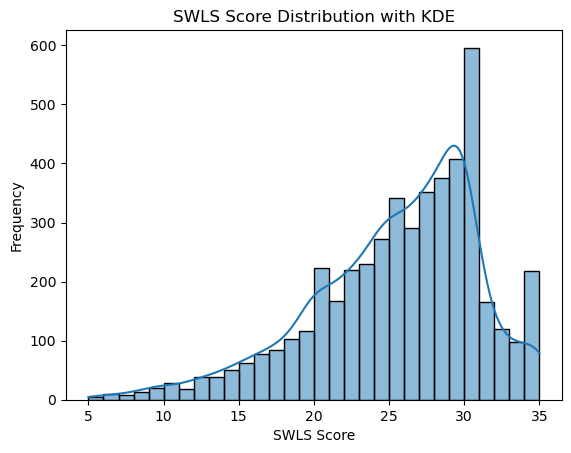

In [11]:
sns.histplot(dataset.swls_score, kde=True, bins=30)
plt.xlabel('SWLS Score')
plt.ylabel('Frequency')
plt.title('SWLS Score Distribution with KDE')
plt.show()

## Get Selected features

In [12]:
# Data splitting
X = dataset.drop(columns=['swls_score', 'nomem_encr'])
y = dataset['swls_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Filter the dataset to the selected features**
X_train_selected = X_train
X_test_selected = X_test

## Gradient Boosting with Hyperparameter Tuning and Feature Selection

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np

estimator = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # 去掉 'auto'
}

# Hyperparameter tuning with GridSearchCV
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
grid_search = GridSearchCV(estimator, param_grid, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
grid_search.fit(X_train_selected, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [17]:
best_estimator = GradientBoostingRegressor(**best_params, random_state=42)
best_estimator.fit(X_train_selected, y_train)

# Train set evaluation
train_r2 = r2_score(y_train, best_estimator.predict(X_train_selected))
train_mae = mean_absolute_error(y_train, best_estimator.predict(X_train_selected))
train_rmse = root_mean_squared_error(y_train, best_estimator.predict(X_train_selected))

# Test set evaluation
test_r2 = r2_score(y_test, best_estimator.predict(X_test_selected))
test_mae = mean_absolute_error(y_test, best_estimator.predict(X_test_selected))
test_rmse = root_mean_squared_error(y_test, best_estimator.predict(X_test_selected))

print("\nGridSearchCV results:")
print(f"Best mean cross-validation R² score: {grid_search.best_score_}")

print("\nTraining R² Score:", train_r2)
print("Training MAE Score:", train_mae)
print("Training RMSE Score:", train_rmse)

print("\nTest R² Score:", test_r2)
print("Test MAE Score:", test_mae)
print("Test RMSE Score:", test_rmse)



GridSearchCV results:
Best mean cross-validation R² score: 0.34590143181665584

Training R² Score: 0.4632281778914211
Training MAE Score: 3.145063718021608
Training RMSE Score: 4.061163047641987

Test R² Score: 0.40639694936958193
Test MAE Score: 3.371756961027746
Test RMSE Score: 4.414168587095834


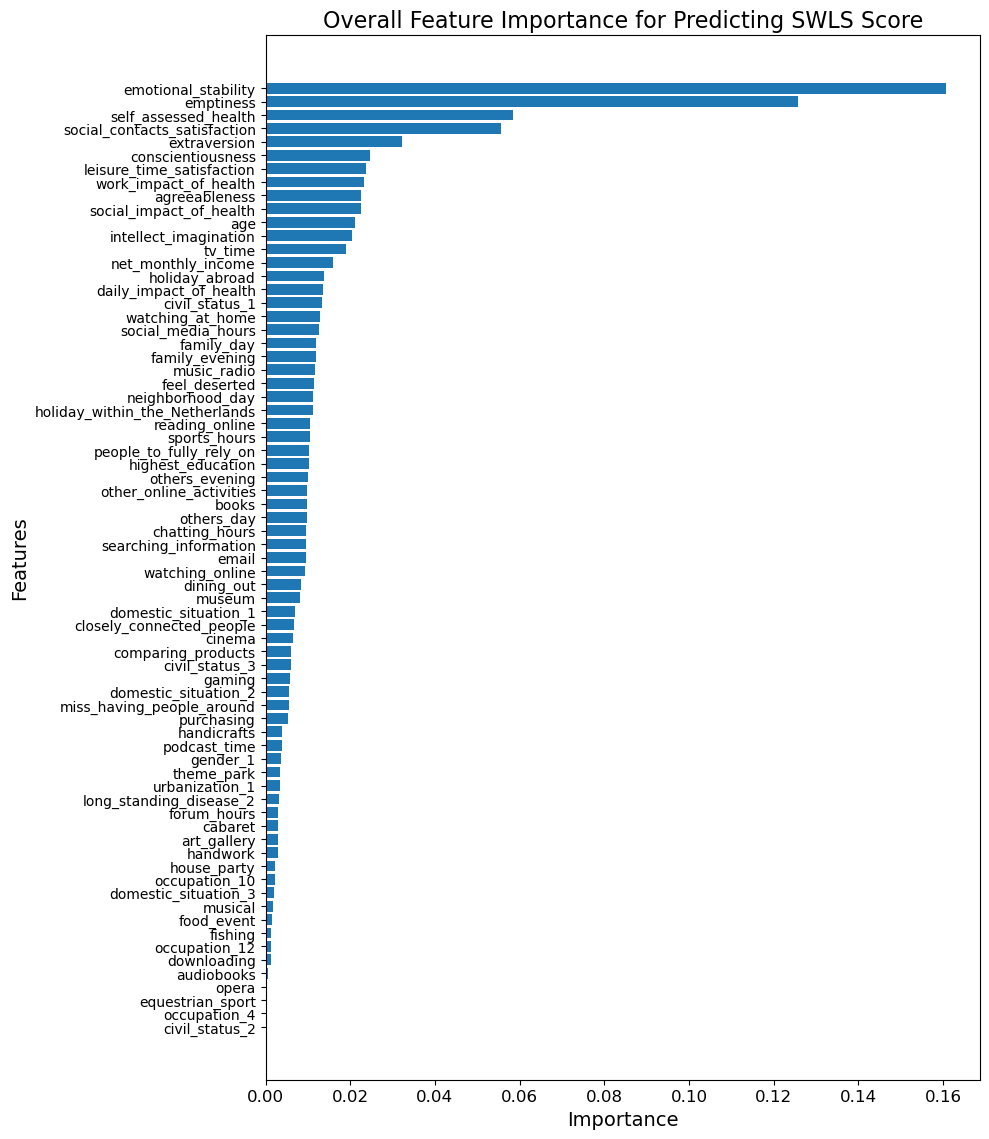

In [35]:
plt.figure(figsize=(10, 11.5))  
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.gca().invert_yaxis()  
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Overall Feature Importance for Predicting SWLS Score', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)  
plt.tight_layout() 
plt.show()

## Random Forest with Hyperparameter Tuning:

In [15]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

estimator = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  
}

# Hyperparameter tuning with GridSearchCV
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
grid_search = GridSearchCV(estimator, param_grid, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
grid_search.fit(X_train_selected, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_estimator = RandomForestRegressor(**best_params, random_state=42)
best_estimator.fit(X_train_selected, y_train)

# Train set evaluation
train_r2 = r2_score(y_train, best_estimator.predict(X_train_selected))
train_mae = mean_absolute_error(y_train, best_estimator.predict(X_train_selected))
train_rmse = root_mean_squared_error(y_train, best_estimator.predict(X_train_selected))

# Test set evaluation
test_r2 = r2_score(y_test, best_estimator.predict(X_test_selected))
test_mae = mean_absolute_error(y_test, best_estimator.predict(X_test_selected))
test_rmse = root_mean_squared_error(y_test, best_estimator.predict(X_test_selected))

cv_results = grid_search.cv_results_
print("\nGridSearchCV results:")
print(f"Best mean cross-validation R² score: {grid_search.best_score_}")

print("\nTraining R² Score:", train_r2)
print("Training MAE Score:", train_mae)
print("Training RMSE Score:", train_rmse)

print("\nTest R² Score:", test_r2)
print("Test MAE Score:", test_mae)
print("Test RMSE Score:", test_rmse)


Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

GridSearchCV results:
Best mean cross-validation R² score: 0.3303061552585871

Training R² Score: 0.7043416536576063
Training MAE Score: 2.3343263600028212
Training RMSE Score: 3.014051321417232

Test R² Score: 0.37768878089904423
Test MAE Score: 3.4747281229024285
Test RMSE Score: 4.519648589953163


## LASSO Regression with Hyperparameter Tuning

In [14]:
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

lasso = Lasso(random_state=42)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]  
}

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
grid_search = GridSearchCV(lasso, param_grid, scoring='r2', cv=cv, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

best_lasso = Lasso(alpha=best_alpha, random_state=42)

r2_scores = cross_val_score(best_lasso, X_train_selected, y_train, cv=cv, scoring='r2')
mae_scores = cross_val_score(best_lasso, X_train_selected, y_train, cv=cv, scoring='neg_mean_absolute_error')
rmse_scores = cross_val_score(best_lasso, X_train_selected, y_train, cv=cv, scoring='neg_root_mean_squared_error')

print("Cross-validation R² scores:", r2_scores)
print("Mean cross-validation R² score:", np.mean(r2_scores))

print("Cross-validation MAE scores:", -mae_scores) 
print("Mean cross-validation MAE score:", -np.mean(mae_scores))

print("Cross-validation RMSE scores:", -rmse_scores) 
print("Mean cross-validation RMSE score:", -np.mean(rmse_scores))

best_lasso.fit(X_train_selected, y_train)

# Train set evaluation
train_r2 = r2_score(y_train, best_lasso.predict(X_train_selected))
train_mae = mean_absolute_error(y_train, best_lasso.predict(X_train_selected))
train_rmse = root_mean_squared_error(y_train, best_lasso.predict(X_train_selected))

# Test set evaluation
test_r2 = r2_score(y_test, best_lasso.predict(X_test_selected))
test_mae = mean_absolute_error(y_test, best_lasso.predict(X_test_selected))
test_rmse = root_mean_squared_error(y_test, best_lasso.predict(X_test_selected))   # 手动计算 RMSE

print("\nTraining R² Score:", train_r2)
print("Training MAE Score:", train_mae)
print("Training RMSE Score:", train_rmse)

print("\nTest R² Score:", test_r2)
print("Test MAE Score:", test_mae)
print("Test RMSE Score:", test_rmse)


Best alpha: 0.01
Cross-validation R² scores: [0.34129202 0.37747472 0.30227853 0.340042   0.35499267 0.39261041
 0.32496829 0.36154411 0.30864439 0.32643282 0.37771901 0.33754415
 0.30945239 0.35256038 0.31291279 0.35605048 0.34109621 0.35709707
 0.35333604 0.31477659 0.39140399 0.33325383 0.33491865 0.28735265
 0.35967938]
Mean cross-validation R² score: 0.3419773430575212
Cross-validation MAE scores: [3.43433929 3.50102524 3.4950111  3.52632056 3.42528841 3.38490218
 3.54737722 3.40063169 3.44168986 3.62588836 3.36503689 3.39419968
 3.41081963 3.63509729 3.60814577 3.41265925 3.55300795 3.47599764
 3.53859258 3.42343374 3.39209751 3.39303814 3.4734153  3.75933307
 3.41510171]
Mean cross-validation MAE score: 3.4812980020715383
Cross-validation RMSE scores: [4.5062985  4.44504612 4.56030386 4.50913091 4.42246247 4.34435097
 4.66003417 4.36801507 4.43492233 4.64640598 4.40197365 4.38186453
 4.40431796 4.66403918 4.65021079 4.38651463 4.57160365 4.41446684
 4.57689984 4.47315248 4.33534

## Multiple Linear Regression

In [13]:
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

estimator = LinearRegression()

# Repeated Cross Validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = cross_val_score(estimator, X_train_selected, y_train, cv=cv, scoring='r2')
mae_scores = cross_val_score(estimator, X_train_selected, y_train, cv=cv, scoring='neg_mean_absolute_error')
rmse_scores = cross_val_score(estimator, X_train_selected, y_train, cv=cv, scoring='neg_root_mean_squared_error')

print("Cross-validation R² scores:", r2_scores)
print("Mean cross-validation R² score:", np.mean(r2_scores))

print("Cross-validation MAE scores:", -mae_scores)  
print("Mean cross-validation MAE score:", -np.mean(mae_scores))

print("Cross-validation RMSE scores:", -rmse_scores)  
print("Mean cross-validation RMSE score:", -np.mean(rmse_scores))

estimator.fit(X_train_selected, y_train)

# Train set evaluation
train_r2 = r2_score(y_train, estimator.predict(X_train_selected))
train_mae = mean_absolute_error(y_train, estimator.predict(X_train_selected))
train_rmse = root_mean_squared_error(y_train, estimator.predict(X_train_selected))

# Test set evaluation
test_r2 = r2_score(y_test, estimator.predict(X_test_selected))
test_mae = mean_absolute_error(y_test, estimator.predict(X_test_selected))
test_rmse = root_mean_squared_error(y_test, estimator.predict(X_test_selected))

print("\nTraining R² Score:", train_r2)
print("Training MAE Score:", train_mae)
print("Training RMSE Score:", train_rmse)

print("\nTest R² Score:", test_r2)
print("Test MAE Score:", test_mae)
print("Test RMSE Score:", test_rmse)


Cross-validation R² scores: [0.33782122 0.37251331 0.30434076 0.3409679  0.34446778 0.38900689
 0.32345077 0.36386143 0.30260248 0.31983367 0.37478577 0.32714414
 0.29796409 0.34902875 0.29815142 0.34920944 0.33168077 0.34844602
 0.3556565  0.31082488 0.39108808 0.3270194  0.33136691 0.28583714
 0.35231418]
Mean cross-validation R² score: 0.3371753480545434
Cross-validation MAE scores: [3.44976941 3.51955485 3.48107454 3.51991419 3.45919801 3.3827446
 3.55329049 3.39725604 3.45902849 3.64345206 3.36226518 3.4106393
 3.43728713 3.63478911 3.64576955 3.43314589 3.58056097 3.48973566
 3.53511502 3.42795408 3.3988338  3.40579205 3.47427127 3.76397569
 3.43171882]
Mean cross-validation MAE score: 3.4918854476122076
Cross-validation RMSE scores: [4.51815498 4.46272407 4.55355951 4.50596672 4.45839815 4.35721901
 4.66526928 4.36008086 4.45425908 4.66911166 4.41233624 4.41612642
 4.44080309 4.67674248 4.69989786 4.40975326 4.60415089 4.44406863
 4.5686807  4.48603236 4.33647074 4.39281131 4.51